**Determining the level of Understanding Students have in a Class**

**Introduction:**

A student’s knowledge status can be obtained by analyzing their exam performance in relation to the method of preparation the student used. A user modeling system provides customized suitable knowledge for users according to their knowledge class. Using the student’s knowledge about the data can supply insight into which attribute, in the process of preparation for an exam, has the largest contribution to the user’s knowledge class. The knowledge class of the users was classified by using an intuitive knowledge classifier, which explores the optimum weight values of students’ features on their knowledge class, and k-nearest neighbor algorithm. The dataset we will be using in this project is the User Knowledge Modeling Data Set. It contains the data of students’ knowledge status about Electrical DC machines with a total of 403 instances and using five attributes: STG, SCG, STR, LPR and PEG. Our objective is to be able to determine what a student's UNS is based on on the five attributes. 

STG : The degree of study time for goal object materials

SCG : The degree of repetition number of user for goal object materials

STR : The degree of study time of user for related objects with goal object 

LPR : The exam performance of user for related objects with goal object

PEG : The exam performance of user for goal objects

UNS : Knowledge level of the user

**Method & Data Analysis:**

We will be using classification analysis as the main method for the project. All five of the attributes, excluding the attribute “UNS” which is the variable to be predicted, are used as predictors. The justification behind using all five of the attributes is listed below:

* Study Time (STG and STR): The longer an individual studies for, the more knowledge they are able to absorb.

* Repetition (SCG): The more times an individual studies a piece of content, the more effiectively the knowledge is retained.

* Exam Preformances (LPR and PEG): Exams are a good indicator of how effective an individual has retained and able to retrieve the knowledge.

To begin, all the necessary packages for this project are loaded and stored into R using the library function. Using the download.file function, the data set was downloaded from the University of California Irvine’s archives and stored into the “data” folder. This then allows the data to be uploaded onto R using the read_excel function.

The data set has already been wrangled, standardized, and split into both testing and training data, therefore the only thing we did was arrange the UNS by class, concluding the tidying and preprocessing stage.   

Additionally, by setting a seed, it allows the results of the KNN classification to be reproducible while being completely fair, unbiased, and not influenced by human input.

In [63]:
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(readxl)
library(repr)
library(dplyr)
library(tidyverse)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
library(tidyverse)

# your code here
set.seed(2022)
download.file(url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls")
user_knowledge_training <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls",sheet ="Training_Data",range = cell_cols("A:F"))
user_knowledge_testing <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls",sheet ="Test_Data",range = cell_cols("A:F"))
user_knowledge_training <- user_knowledge_training %>%
    mutate(UNS = factor(UNS, levels = c('very_low','Low','Middle','High'))) %>%
    arrange(UNS)

user_knowledge_testing$UNS[which(user_knowledge_testing$UNS=='Very Low')]<-'very_low'
user_knowledge_testing <- user_knowledge_testing %>%
    mutate(UNS = factor(UNS, levels = c('very_low','Low','Middle','High'))) %>%
    arrange(UNS)
print("Table 1 : User Knowledge Training Dataset")
user_knowledge_training
print("Table 2 : User Knowledge Testing Dataset")
user_knowledge_testing


[1] "Table 1 : User Knowledge Training Dataset"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.15,0.02,0.34,0.40,0.01,very_low
0.05,0.07,0.70,0.01,0.05,very_low
⋮,⋮,⋮,⋮,⋮,⋮
0.61,0.78,0.69,0.92,0.58,High
0.54,0.82,0.71,0.29,0.77,High
0.66,0.90,0.76,0.87,0.74,High


[1] "Table 2 : User Knowledge Testing Dataset"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.16,0.25,0.01,0.10,0.07,very_low
0.18,0.26,0.05,0.40,0.04,very_low
⋮,⋮,⋮,⋮,⋮,⋮
0.78,0.47,0.29,0.98,0.59,High
0.90,0.78,0.62,0.32,0.89,High
0.85,0.82,0.66,0.83,0.83,High


In order to select the best $K$ value used during the KNN classification, the training data set has be tuned by undergoing a 5-fold cross-validation and parameter value selection.

The vfold_cv function splits the training data into 5 different folds that contains the fair proportions respective to the UNS. 

The nearest_neighbor function is then used to create a new model specifications for the KNN classification. By specifying the weight function to be rectangular, each of the KNN gets 1 vote when classifying the new observation. As for the $K$ value, we replaced it with tune (), which is necessary when identifying the best $K$ value. It should also be noted that the engine was set to "kknn" which is the weighted K-nearest neighbor algorithm, and the mode was set to "classification".

We then created a data analysis workflow (knn_results), adding the recipe and the KNN classifcation model, while running cross-validation on each split. The tune_grid function fits the model (knn_tune) within a range of parameter values. Additionally, the collect_metrics function calculates the mean and standard error of the classifier’s validation accuracy across the folds.

A line graph is then plotted to help us observe the relationship between the $K$ value and the accuracy of the estimates, this will help determine which $K$ value is the best fit. 


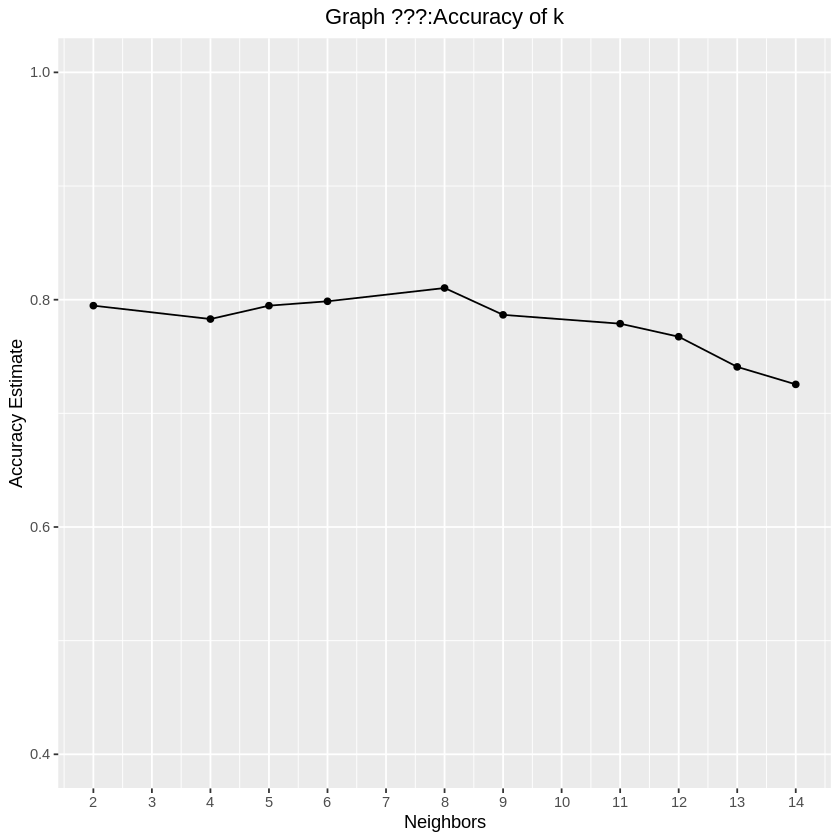

In [77]:
user_knowledge_vfold<- vfold_cv(user_knowledge_training, v = 5, strata = UNS)

user_knowledge_resample_fit <- workflow() %>%
      add_recipe(user_knowledge_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = user_knowledge_vfold)

user_knowledge_metrics <- user_knowledge_resample_fit %>%
            collect_metrics()

knn_tune <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_results <- workflow() %>%
    add_recipe(user_knowledge_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
     collect_metrics()

accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
      ggtitle("Graph ???:Accuracy of k") +
      theme(plot.title = element_text(hjust = 0.5)) 
accuracy_versus_k


From the graph above, we decided that $K = 3$ is the best K value to use while performing the KNN classification for this data set. This is because, any $K$ value between 3-10 is very similar, hovering slightly above or below the 80% range. Therefore, we decided to go with the lowest $K$ value to keep the cost relatively lower. 

We then were able to recreate the KNN classification with $K=3$ from the training dataset, and then predicting the UNS in the testing dataset. A confusion matrix of the prediction was then created to help evaluate the accuracy of the classifer.

In [73]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
      set_engine("kknn") %>%
      set_mode("classification")

user_knowledge_fit <- workflow() %>%
      add_recipe(user_knowledge_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = user_knowledge_training)

user_knowledge_test_predictions <- predict(user_knowledge_fit , user_knowledge_testing) %>%
      bind_cols(user_knowledge_testing)
print("Table 3 : Prediction of User Knowledge Testing Dataset")
user_knowledge_test_predictions

user_knowledge_prediction_accuracy <- user_knowledge_test_predictions %>%
        metrics(truth = UNS, estimate = .pred_class) 
print("Table 4 : Prediction Accuracy")
user_knowledge_prediction_accuracy

user_knowledge_mat <- user_knowledge_test_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)
print("Table 5 : Confusion Matrix of UNS")
user_knowledge_mat

[1] "Table 3 : Prediction of User Knowledge Testing Dataset"


.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
very_low,0.00,0.10,0.50,0.26,0.05,very_low
Low,0.16,0.25,0.01,0.10,0.07,very_low
very_low,0.18,0.26,0.05,0.40,0.04,very_low
⋮,⋮,⋮,⋮,⋮,⋮,⋮
High,0.78,0.47,0.29,0.98,0.59,High
Middle,0.90,0.78,0.62,0.32,0.89,High
High,0.85,0.82,0.66,0.83,0.83,High


[1] "Table 4 : Prediction Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8206897
kap,multiclass,0.7545253


[1] "Table 5 : Confusion Matrix of UNS"


          Truth
Prediction very_low Low Middle High
  very_low       15   3      0    0
  Low            11  41      6    0
  Middle          0   2     27    3
  High            0   0      1   36

To help visualize the distribution of the UNS, we created a bar chart.

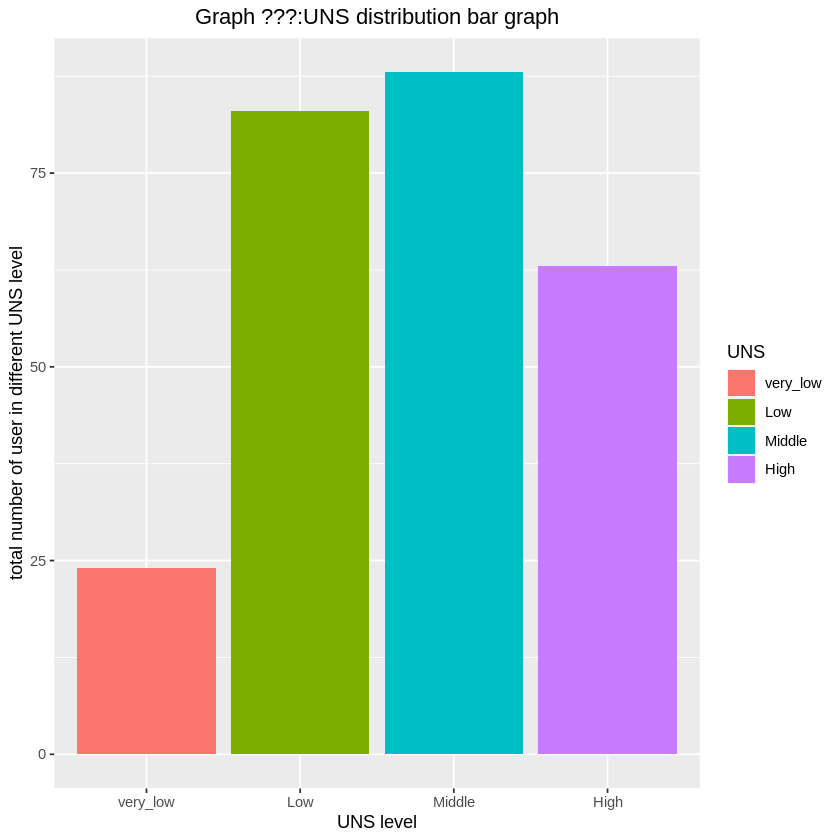

In [69]:
count_uns <- user_knowledge_training %>%
    group_by(UNS) %>%
    count(UNS)

count_bar_chart <- ggplot(count_uns, aes(x = UNS, y = n, fill= UNS)) + 
    geom_bar(stat = "identity") +
    ggtitle("Graph ???:UNS distribution bar graph") +
    xlab("UNS level") +
    ylab("total number of user in different UNS level") +
    theme(plot.title = element_text(hjust = 0.5)) 
count_bar_chart

From the graph above, it is clear that the level of UNS is quite normally distributed. Suggesting that the middle UNS has the largest distribution, while there is relatively lower distribution in the lower and upper ends.

To help visualize the relationship between each predictor and the UNS, we created scatter plots that presented the relationship between each predictor and the UNS.

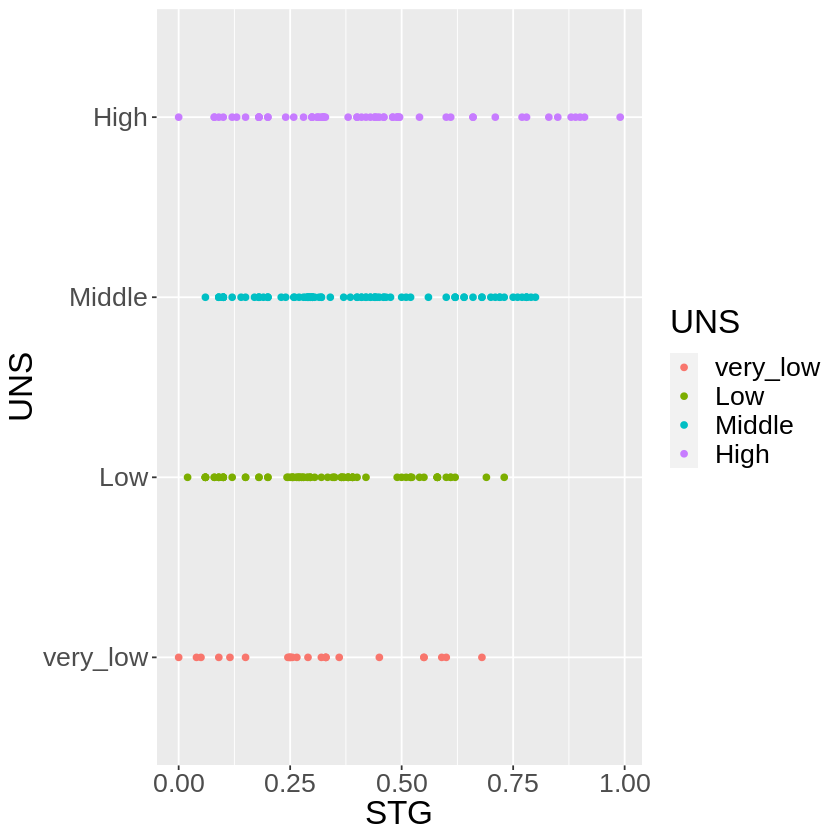

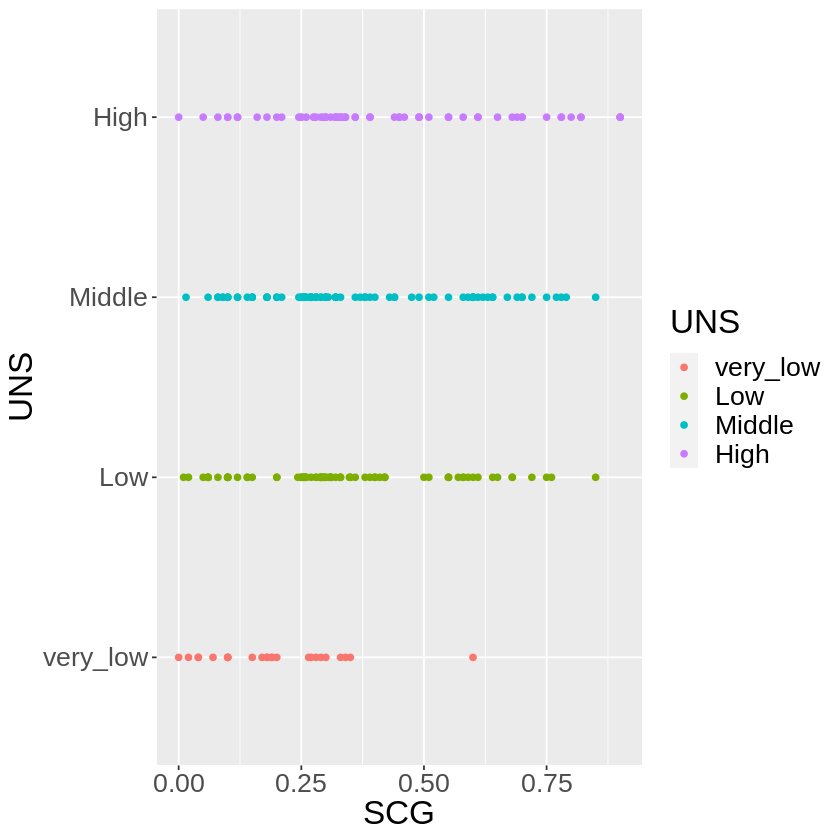

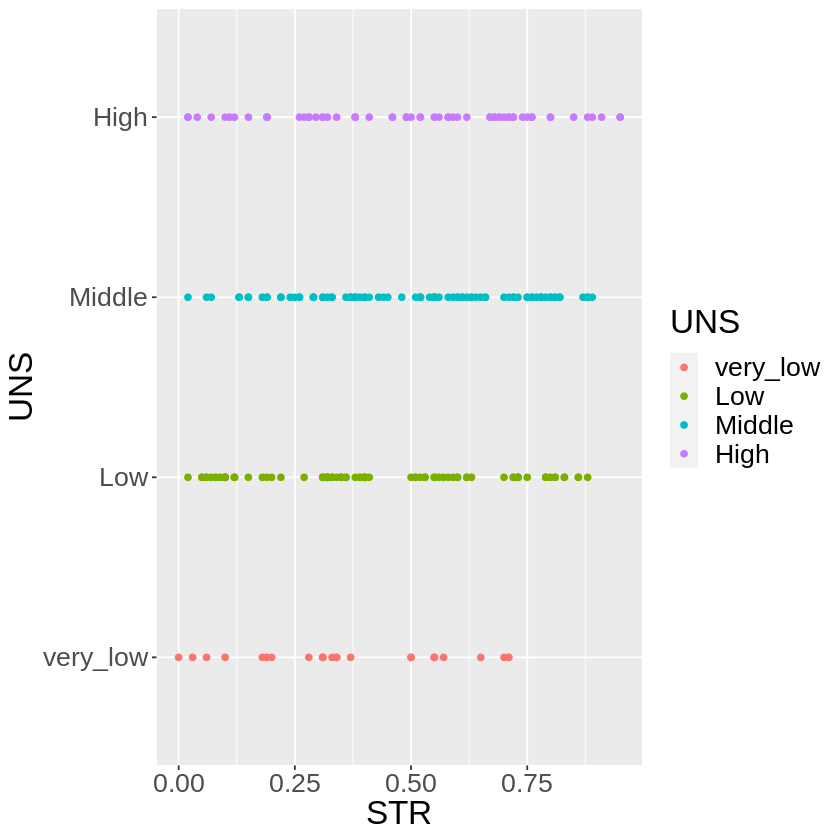

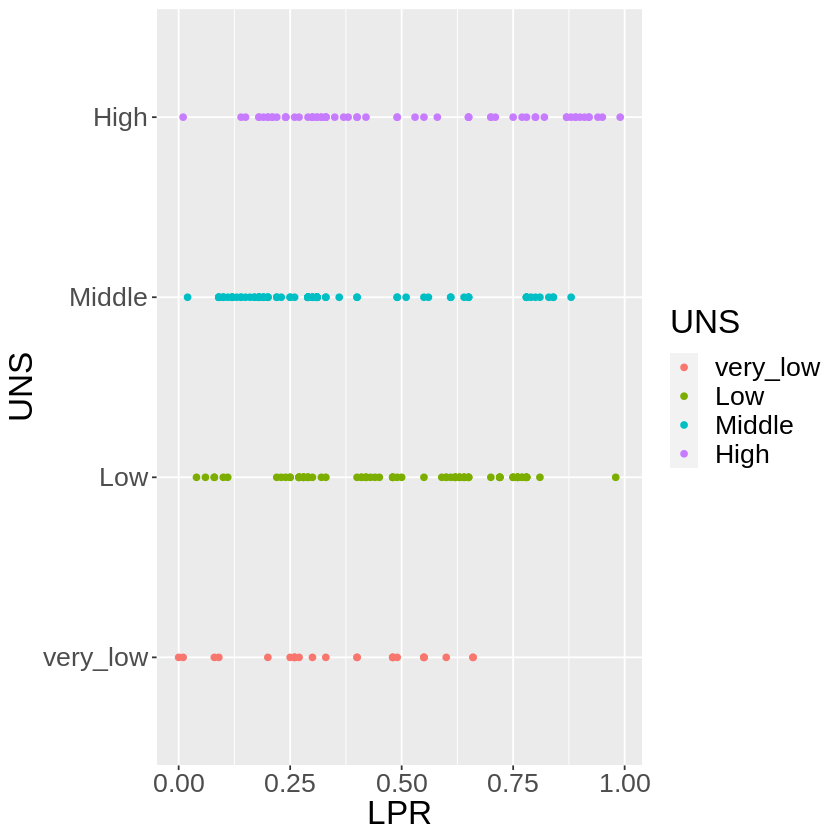

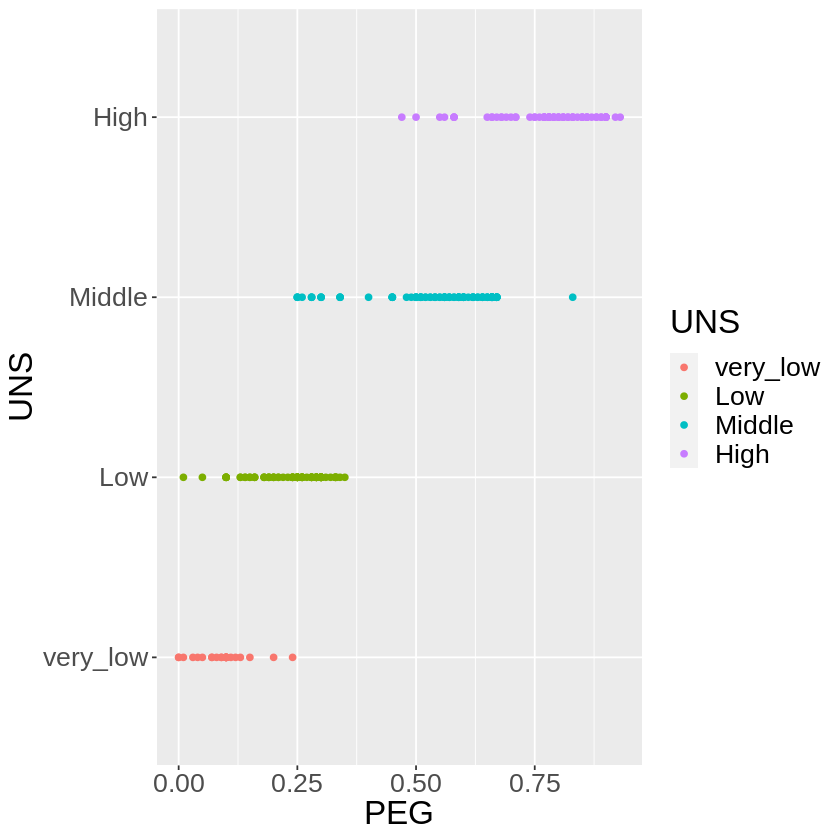

In [49]:
STG <- ggplot(user_knowledge_training, aes(x = STG, y = UNS, colour = UNS)) +
    geom_point()  +
    ggtitle("Graph ???:STG vs UNS") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(text = element_text(size = 20))
STG

SCG <- ggplot(user_knowledge_training, aes(x = SCG, y = UNS ,colour = UNS)) +
    geom_point() + 
    ggtitle("Graph ???:STG vs UNS") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(text = element_text(size = 20))
SCG

STR <- ggplot(user_knowledge_training, aes(x = STR, y = UNS ,colour = UNS)) +
    geom_point() +
    ggtitle("Graph ???:STG vs UNS") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(text = element_text(size = 20))
STR

LPR <- ggplot(user_knowledge_training, aes(x = LPR, y = UNS ,colour = UNS)) +
    geom_point()  +
    ggtitle("Graph ???:STG vs UNS") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(text = element_text(size = 20))
LPR

PEG <- ggplot(user_knowledge_training, aes(x = PEG, y = UNS ,colour = UNS)) +
    geom_point()  +
    ggtitle("Graph ???:STG vs UNS") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(text = element_text(size = 20))
PEG

**Discussion:**

**References:**

**Group Members:**


Geng Chen(51264893), Brendan Cheng(54085402)